# On recupère les datas

In [177]:
from pickle import Unpickler as Upck
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn import tree
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, DotProduct
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor


from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, normalize
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_validate, cross_val_score, ShuffleSplit, KFold, RepeatedKFold, LeaveOneOut, LeavePOut, StratifiedKFold, RepeatedStratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, r2_score, mean_absolute_percentage_error

pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)

with open('/home/sylvain/Téléchargements/X_file_3', 'rb') as file:
    myPickler = Upck(file)
    data= myPickler.load()

with open('/home/sylvain/Téléchargements/energystar', 'rb') as file:
    myPickler = Upck(file)
    energystar = myPickler.load()

# Data leakage

### Data leakage de manière a supprimer le problème de data leakage, on split les datas Train / Test 

In [178]:
# On recupere X et y
X = data[:, :-2]
y = data[:, -2:] #les 2 dernière colonnes de data: Emission et Energie 

#On split le data set en train set et test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Data leakage et Encoding 

###  On encode les variables categorielle avec du OneHot Encoding. il n'y a pas d'Ordinalité dans les données. On limite  le  data leakage avec OneHot Encoding car on fit l'encoder sur les datas Train uniquement. 

In [179]:
# On encode les data categorielles en vecteur
encHot = OneHotEncoder(handle_unknown = 'ignore')
X_train = np.hstack([X_train, encHot.fit_transform(X_train[:, 0].reshape(-1, 1)).toarray()])
X_test = np.hstack([X_test, encHot.transform(X_test[:, 0].reshape(-1, 1)).toarray()])
X_train = np.delete(X_train, 0, 1)
X_test = np.delete(X_test, 0, 1)
                   
encHot = OneHotEncoder(handle_unknown = 'ignore')
X_train = np.hstack([X_train, encHot.fit_transform(X_train[:, 2].reshape(-1, 1)).toarray()])
X_test = np.hstack([X_test, encHot.transform(X_test[:, 2].reshape(-1, 1)).toarray()])
X_train = np.delete(X_train, 2, 1)
X_test = np.delete(X_test, 2, 1)

### Data leakage Cross Validation et Standardisation, on crée un pipeline de manière a ne pas standardiser X_train car lors de la cross validation le Fold servant a la validation sera deja standardiser d'où le risque de dataleakage.
### La cross validation ce fera directement avec la recherche des meilleur paramètres pour les différents estimateurs avec 'GridSearchCV'

### On définit les estimateurs, on creer un pipeline pour la standardisation des variable et on fait varier leurs paramètres pour la GridSearhCV

In [180]:
########################
#linear regression
'''
reg_lr = make_pipeline(StandardScaler(), LinearRegression()
tuned_parameters_lr = {'fit_intercept': [True, False], 
                   'normalize': [True, False]} '''

reg_lr = Pipeline(steps = [('std', StandardScaler()), ('lr', LinearRegression())])
tuned_parameters_lr = {'lr__fit_intercept': [True, False], 
                       'lr__normalize': [True, False]}
                       
########################
#tree regressor

'''
reg_t = tree.DecisionTreeRegressor()
tuned_parameters_t = {'criterion' : ['mse', 'friedman_mse', 'mae, poisson'],
                    'max_depth': [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 
                    'min_samples_split': [3, 4, 5, 6, 7, 8, 9, 10, 11], 
                    'splitter': ['best','random'],
                    'min_samples_leaf': [1, 2, 3, 4],
                    'max_features': ['auto', 'sqrt', 'log2']}'''

reg_t = Pipeline(steps = [('std', StandardScaler()), ('t', tree.DecisionTreeRegressor())])
tuned_parameters_t = {'t__criterion' : ['mse'],
                    't__max_depth': [ 4, 7, 10], 
                    't__min_samples_split': [4 , 7, 10], 
                    't__splitter': ['best'],
                    't__min_samples_leaf': [2, 3, 4],
                    't__max_features': ['auto']}

########################
#KNeighbors
'''
reg_kn = KNeighborsRegressor()
tuned_parameters_kn = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                    'weights': ['uniform', 'distance'],
                    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'p': [1, 2]}
                    '''
reg_kn = Pipeline(steps = [('std', StandardScaler()), ('kn', KNeighborsRegressor())])
tuned_parameters_kn = {'kn__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                    'kn__weights': ['uniform', 'distance'],
                    'kn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'kn__p': [1, 2]}

########################
#Neural Network
'''
reg_nn = MLPRegressor()
tuned_parameters_nn = {'hidden_layer_sizes': [(8,), (10,), (8, 8), (10, 8)],
                    'activation': ['identity', 'logistic', 'tanh', 'relu'],
                    'solver': ['lbfgs', 'sgd', 'adam'],
                    'alpha': [0.001, 0.0001, 0.00001],
                    'learning_rate': ['constant', 'invscaling', 'adaptive'],
                    'max_iter': [200],
                    'tol' : [0.0001]} : '''

reg_nn = Pipeline(steps = [('std', StandardScaler()), ('nn', MLPRegressor())])
tuned_parameters_nn = {'nn__hidden_layer_sizes': [(8,), (10,), (8, 8), (10, 8)],
                       'nn__activation': ['logistic'],
                       'nn__solver': ['lbfgs'],
                       'nn__alpha': [0.001, 0.0001, 0.00001],
                       'nn__learning_rate': ['adaptive'],
                       'nn__max_iter': [800],
                       'nn__tol' : [0.0001]}

###########################
#Random Forest
'''
reg_rf = Pipeline(steps = [('std', StandardScaler()), ('rf', RandomForestRegressor())])
tuned_parameters_rf = {'rf__n_estimators': [50, 125, 150, 200, 250, 300],
                    'rf__criterion' : ['mse', 'mae'],
                    'rf__max_depth': [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 
                    'rf__min_samples_split': [3, 5, 8], 
                    'rf__min_samples_leaf': [1, 3],
                    'rf__bootstrap': [True, False],
                    'rf__max_features': ['auto', 'sqrt', 'log2']}'''

reg_rf = Pipeline(steps = [('std', StandardScaler()), ('rf', RandomForestRegressor())])
tuned_parameters_rf = {'rf__n_estimators': [50, 125, 150, 200, 250, 300],
                    'rf__random_state' : [0],
                    'rf__bootstrap': [True]}


# Cross Validation et tunning pour les hyperparamètres  avec GridSearhCV

In [181]:
# liste des estimateurs et de leur hyeperparamètres respectifs
lreg = [reg_lr, 
        reg_t,
        reg_kn,
        reg_nn,
        reg_rf]

ltune = [tuned_parameters_lr,
         tuned_parameters_t,
         tuned_parameters_kn,
         tuned_parameters_nn,
         tuned_parameters_rf]

# Pour ma Cross Validation on choisi 5 Folds, 
# Après avoir fait varier KFold on ne note pas de différence significative
# d'autres cv on était testé comme Shuffle/OneleaveOut
K = 5
cv = KFold(n_splits = K)

# On cree une GridSearch
# On va également faire varier la fonction de perte
score = ['r2',
         'neg_mean_absolute_error',
         'neg_root_mean_squared_error']

score = ['r2']
best = []
for s in score:
    dft = pd.DataFrame()
    
    # On lance une GridSearchCV pour chacun des estimateurs
    for reg, tune in zip(lreg, ltune):  
        R = GridSearchCV(reg, tune, cv = cv, scoring = s, n_jobs = -1)
        R.fit(X_train, y_train)

        # On recupère les resultats dans un dataframe pour la lisibilité 
        
        df = pd.DataFrame(R.cv_results_)
        df = df.rename(columns={'mean_test_score': 'mean_test', 'std_test_score': 'std_test', 'rank_test_score': 'rank'})
        df = df[['params', 'mean_test', 'std_test', 'rank']].sort_values(by=['rank'])
        # On ne garde que le meilleur estimateur/scores obtenus
        dft = dft.append(df[['params', 'mean_test', 'std_test']].iloc[0])
        
        # On récupère le meilleur estimateur pour R²
        if s == 'r2':
            best.append([R, R.best_score_])
        
    # affiche les meilleurs estimateur en fonction de la loss function
    print('\n', 'with loss function: {} \n'.format(s), dft.sort_values(by=['mean_test'], ascending = False), '\n') 

/home/sylvain/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



 with loss function: r2 
         mean_test                                             params  \
5    7.920133e-01  {'rf__bootstrap': True, 'rf__n_estimators': 30...   
209  7.158100e-01  {'kn__algorithm': 'brute', 'kn__n_neighbors': ...   
0    6.692437e-01  {'nn__activation': 'logistic', 'nn__alpha': 0....   
26   6.446726e-01  {'t__criterion': 'mse', 't__max_depth': 10, 't...   
1   -1.582064e+19  {'lr__fit_intercept': True, 'lr__normalize': F...   

         std_test  
5    4.235794e-02  
209  5.050528e-02  
0    4.412566e-02  
26   3.344165e-02  
1    3.164127e+19   



### meilleur estimateur

In [182]:
# On recupère le meilleur estimateur:
best = sorted(best, key = lambda colonnes: colonnes[1], reverse = True)  
Rbest = best[0][0]

# Best estimateur caractéristique
print("Best estimator", Rbest.best_estimator_, '\n')
print("best test score", Rbest.best_score_, '\n')
print("Best parameters", Rbest.best_params_, '\n')

best_n_estimator = Rbest.best_params_['rf__n_estimators'] # on recupere n_estimator pou l'affichage

Best estimator Pipeline(steps=[('std', StandardScaler()),
                ('rf',
                 RandomForestRegressor(n_estimators=300, random_state=0))]) 

best test score 0.7920133480313096 

Best parameters {'rf__bootstrap': True, 'rf__n_estimators': 300, 'rf__random_state': 0} 



# Score validation  du meilleur estimateur sur X_test
### on essaye plusieurs metrics

### On constate que selon la métrique retenue, le paramètres n_estimator diffère mais on voit aussi que l'écart relatif sur les métriques reste très faible.

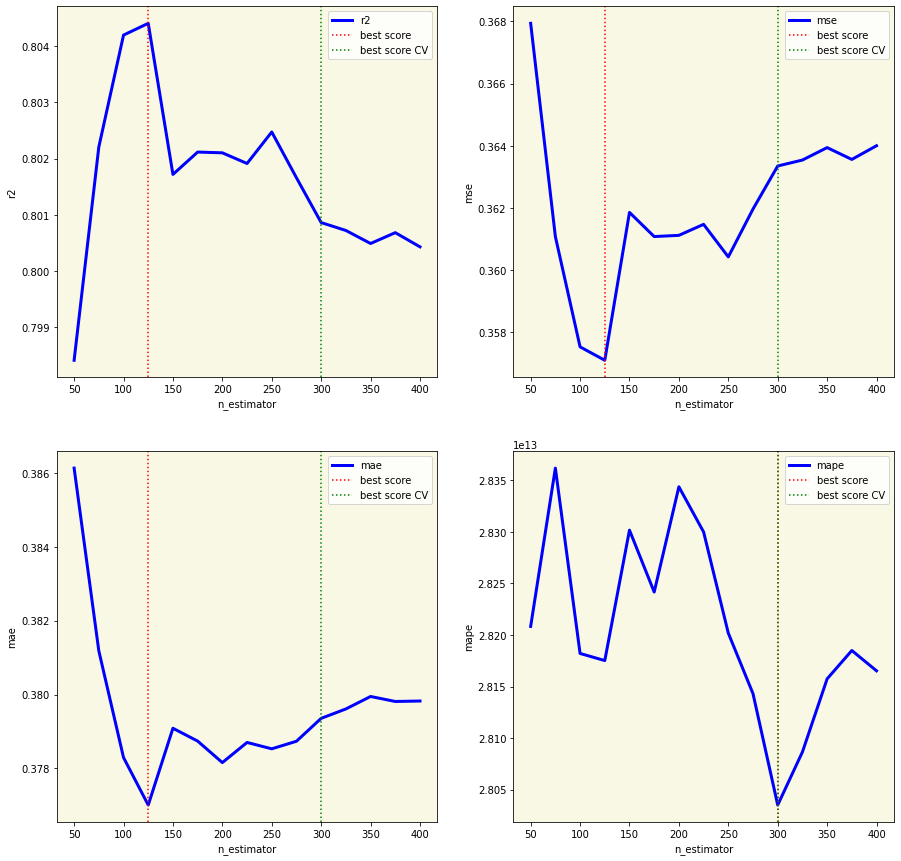

In [183]:
# score obtenu sur Xtest avec le meilleur estimateur
# print('score val: ', Rbest.score(X_test, y_test))

# fonction pour récuperer le paramètre n-estimator pour lequel on a le meilleur score
def return_max(x, score, asc):
    m = list(zip(x, score))
    if asc == 'r2':
        m.sort(key = lambda colonnes : colonnes[1], reverse = True)
    else:
        m.sort(key = lambda colonnes : colonnes[1])
    return m[0][0]

curve_r2 = [] # coef de détermination
curve_mse = [] # mean squared error
curve_mae = [] # mean absolute error
curve_ev = [] # explained variance
curve_mape = [] # mean absolute percentage error
curve = []
Time = []

x = np.linspace(50, 400, 15)

for n_estimators in x:
    
    Rbest = Pipeline(steps = [('std', StandardScaler()), ('rf', RandomForestRegressor(n_estimators = int(n_estimators), random_state = 0, bootstrap = True))])
    
    # Time for fit
    T0 = time.time()
    Rbest.fit(X_train, y_train)
    T1 = time.time()
    Time.append(T1 - T0)
    
    # creation courbe fonction de perte    
    curve_r2.append(r2_score(y_test, Rbest.predict(X_test)))
    curve_mse.append(mean_squared_error(y_test, Rbest.predict(X_test), squared=True))
    curve_mae.append(mean_absolute_error(y_test, Rbest.predict(X_test)))
    # Courbe_ev.append(explained_variance_score(y_test, Rbest.predict(X_test)))
    curve_mape.append(mean_absolute_percentage_error(y_test, Rbest.predict(X_test)))

curve = {'r2': curve_r2, 
         'mse': curve_mse, 
         'mae': curve_mae, 
         'mape':curve_mape}

# Affichage des courbes
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 15))
for i in [0, 1]:
    for j in [0, 1]:
        k = 2*i + j # on itère sur le dico curve
        c = list(curve.keys())[k]
        val = list(curve.values())[k]
        ax[i, j].plot(x, val, label = c, color = 'b', linewidth = 3)
        ax[i, j].axvline(x = return_max(x, val, c), color = 'r', linestyle = ':', label = 'best score')
        ax[i, j].axvline(x = best_n_estimator, color = 'g', linestyle = ':', label = "best score CV")
        ax[i, j].set_ylabel(c)
        ax[i, j].set_xlabel("n_estimator")
        ax[i, j].patch.set_facecolor("y")
        ax[i, j].patch.set_alpha(0.1)
        ax[i, j].legend()
plt.show()

### temps d'apprentissage du modèle

<ipython-input-215-0241ecc95e8a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels = ax.get_yticks(), fontsize = 15)
<ipython-input-215-0241ecc95e8a>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = ax.get_xticks(), fontsize = 15)


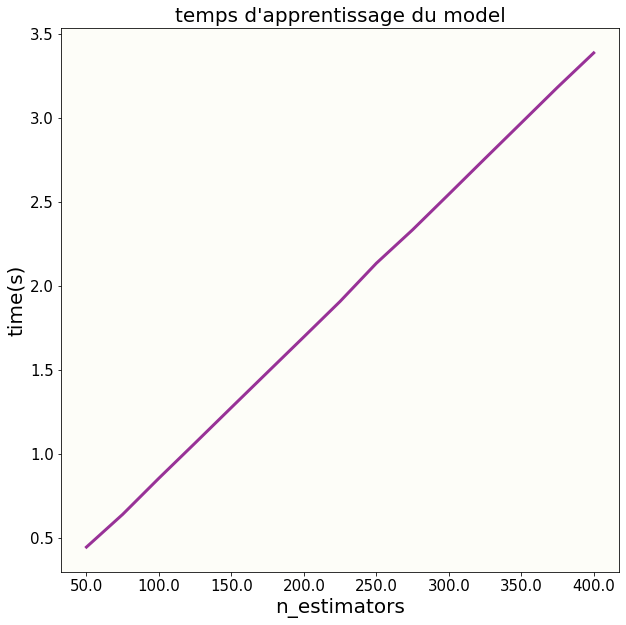

In [215]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(x, Time, color = 'purple', linewidth = 3, alpha = 0.8)
ax.patch.set_facecolor("beige")
ax.patch.set_alpha(0.2)
ax.set_xlabel("n_estimators", fontsize = 20)
ax.set_ylabel("time(s)", fontsize = 20)
ax.set_yticklabels(labels = ax.get_yticks(), fontsize = 15)
ax.set_xticklabels(labels = ax.get_xticks(), fontsize = 15)


ax.set_title("temps d'apprentissage du model", fontsize = 20)
plt.show()

# Comparaison du score R² avec le modèle retenu  (avec et sans energystarscore) pour prédire uniquement les émissions des gaz.

### On modifie les datas de manière a ne pas tenir compte d' energystarscore. On modifie également notre sortie de manière à ne tenir compte que des émissions (et non plus des émssions et de l'énergie totale)  

In [216]:
# On supprime l'energy starscore des data
X_train_s = np.delete(X_train, 8, 1) # suppression de l'energystarsore dans train
X_test_s = np.delete(X_test, 8, 1) # suppression de l'energystarsore dans test
y_train_s = np.delete(y_train, 1, 1) # seulement les emissions
y_test_s = np.delete(y_test, 1, 1) # seulement les emissions



### Cross Validation sur le nouveau dataset (on réapprend un nouveau model)

In [217]:
# hyperparamter optimisation sur le nouveau dataset sans (energy star score)
reg_rf = Pipeline(steps = [('std', StandardScaler()), ('rf', RandomForestRegressor())])
tuned_parameters_rf = {'rf__n_estimators': [50, 125, 150, 200, 250, 300],
                    'rf__random_state' : [0],
                    'rf__bootstrap': [True]}

Rbest_s = GridSearchCV(reg_rf, tuned_parameters_rf, cv = cv, scoring = 'r2', n_jobs = -1)
Rbest_s.fit(X_train_s, y_train_s)

# On recupère les resultats dans un dataframe pour la lisibilité 
df = pd.DataFrame(Rbest_s.cv_results_)
df = df.rename(columns={'mean_test_score': 'mean_test', 'std_test_score': 'std_test', 'rank_test_score': 'rank'})
print(df[['params', 'mean_test', 'std_test', 'rank']].sort_values(by=['rank']))

# Best estimateur caractéristique
print("Best estimator", Rbest_s.best_estimator_, '\n')
print("best test score", Rbest_s.best_score_, '\n')
print("Best parameters", Rbest_s.best_params_, '\n')

/home/sylvain/.local/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


                                              params  mean_test  std_test  \
5  {'rf__bootstrap': True, 'rf__n_estimators': 30...   0.755250  0.103196   
4  {'rf__bootstrap': True, 'rf__n_estimators': 25...   0.753262  0.104406   
0  {'rf__bootstrap': True, 'rf__n_estimators': 50...   0.753023  0.105385   
2  {'rf__bootstrap': True, 'rf__n_estimators': 15...   0.753010  0.107470   
3  {'rf__bootstrap': True, 'rf__n_estimators': 20...   0.752135  0.106103   
1  {'rf__bootstrap': True, 'rf__n_estimators': 12...   0.749627  0.109401   

   rank  
5     1  
4     2  
0     3  
2     4  
3     5  
1     6  
Best estimator Pipeline(steps=[('std', StandardScaler()),
                ('rf',
                 RandomForestRegressor(n_estimators=300, random_state=0))]) 

best test score 0.7552504056927699 

Best parameters {'rf__bootstrap': True, 'rf__n_estimators': 300, 'rf__random_state': 0} 



### On obtient un paramètrage identique

In [219]:
Rbest_s.best_params_

{'rf__bootstrap': True, 'rf__n_estimators': 300, 'rf__random_state': 0}

### On applique une métrique R², on compare la réponse des modèles apprit avec et sans energystarscore. 

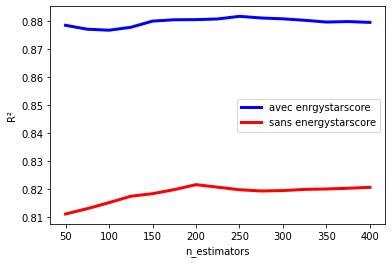

In [220]:
curve_r2 = []
curve_r2_s = []

for n_estimators in x:
    
    # avec energystarscore
    Rbest = Pipeline(steps = [('std', StandardScaler()), ('rf', RandomForestRegressor(n_estimators = int(n_estimators), random_state = 0, bootstrap = True))])
    Rbest.fit(X_train, y_train_s.ravel())
    curve_r2.append(r2_score(y_test_s.ravel(), Rbest.predict(X_test)))
    
    # sans energystarscore
    Rbest_s = Pipeline(steps = [('std_s', StandardScaler()), ('rf_s', RandomForestRegressor(n_estimators = int(n_estimators), random_state = 0, bootstrap = True))])
    Rbest_s.fit(X_train_s, y_train_s.ravel())
    curve_r2_s.append(r2_score(y_test_s.ravel(), Rbest_s.predict(X_test_s)))
    
# Affichage des courbes
plt.plot(x, curve_r2, label = "avec enrgystarscore", color = 'b', linewidth = 3)
plt.plot(x, curve_r2_s, label = "sans energystarscore", color = 'r', linewidth = 3)
plt.ylabel("R²")
plt.xlabel("n_estimators")
plt.legend()
plt.show()

### test satistique sur la différence des réponses des 2 modèles

### Visualisation des résidus

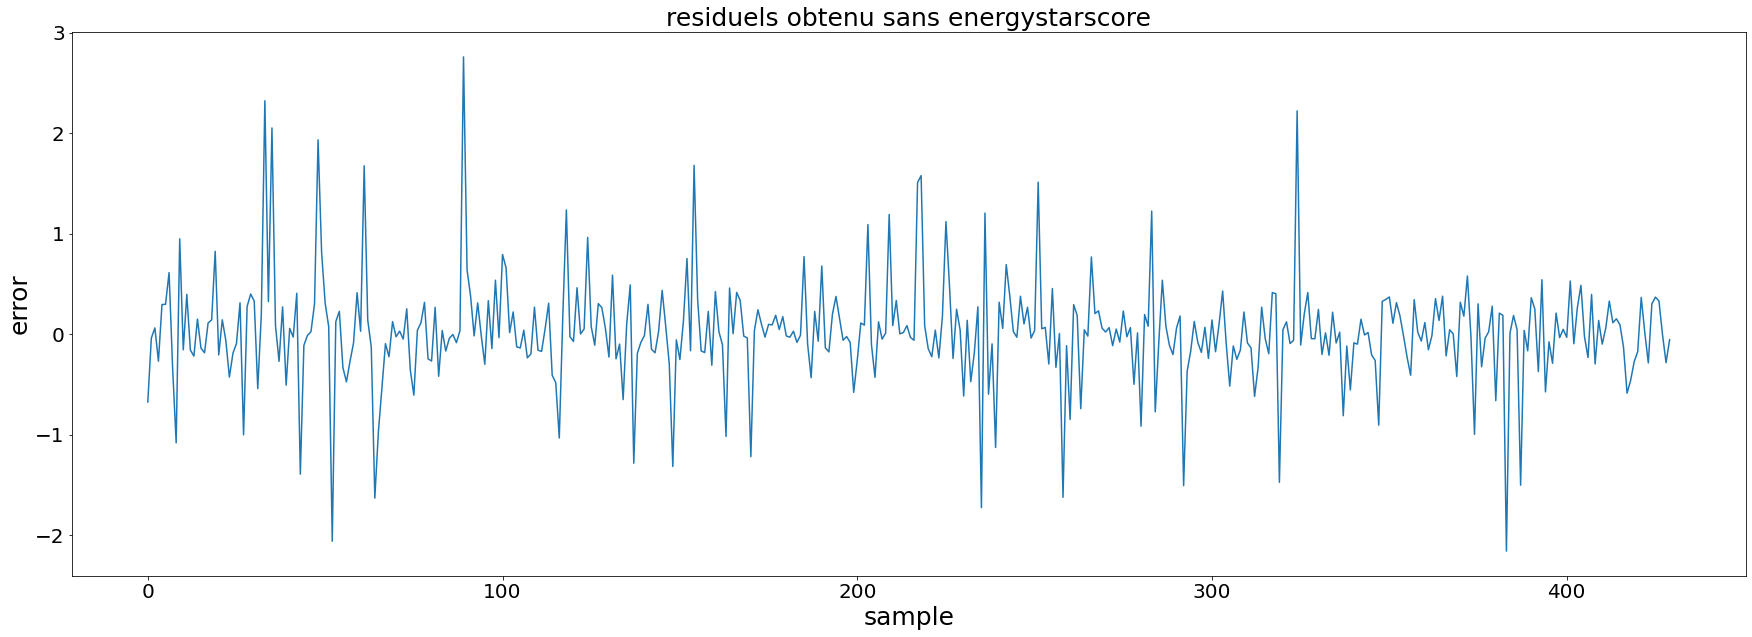

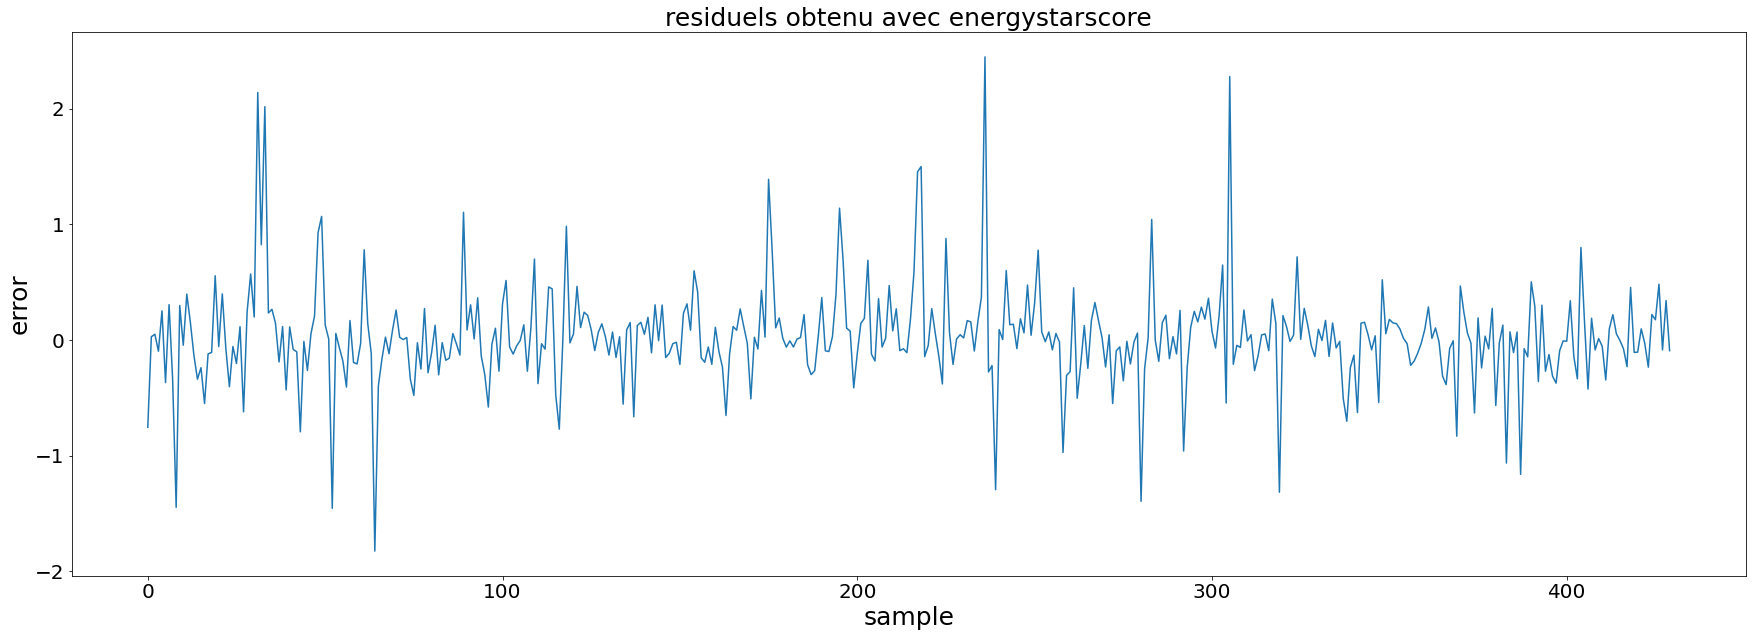

In [221]:
#eps = Rbest.predict(X_test) - Rbest_s.predict(X_test_s)
from scipy.stats import normaltest, norm, gamma, chisquare, f_oneway, kruskal, spearmanr, t, f

# residuels pour le model sans energy star score
eps_s = y_test_s.ravel() - Rbest_s.predict(X_test_s)
x = np.arange(len(X_test[:, 0]))
x = np.arange(len(X_test[:, 0]))
plt.figure(figsize = (30,10))
plt.plot(x, eps_s)
plt.title("residuels obtenu sans energystarscore", fontsize = 25)
plt.xlabel('sample', fontsize = 25)
plt.ylabel('error', fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
fontsize = 20
plt.show()

# residuels pour le model energy star score
eps = y_test_s.ravel() - Rbest.predict(X_test)
x = np.arange(len(X_test[:, 0]))
x = np.arange(len(X_test[:, 0]))
plt.figure(figsize = (30,10))
plt.plot(x, eps)
plt.title("residuels obtenu avec energystarscore", fontsize = 25)
plt.xlabel('sample', fontsize = 25)
plt.ylabel('error', fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
fontsize = 20
plt.show()

plt.show()


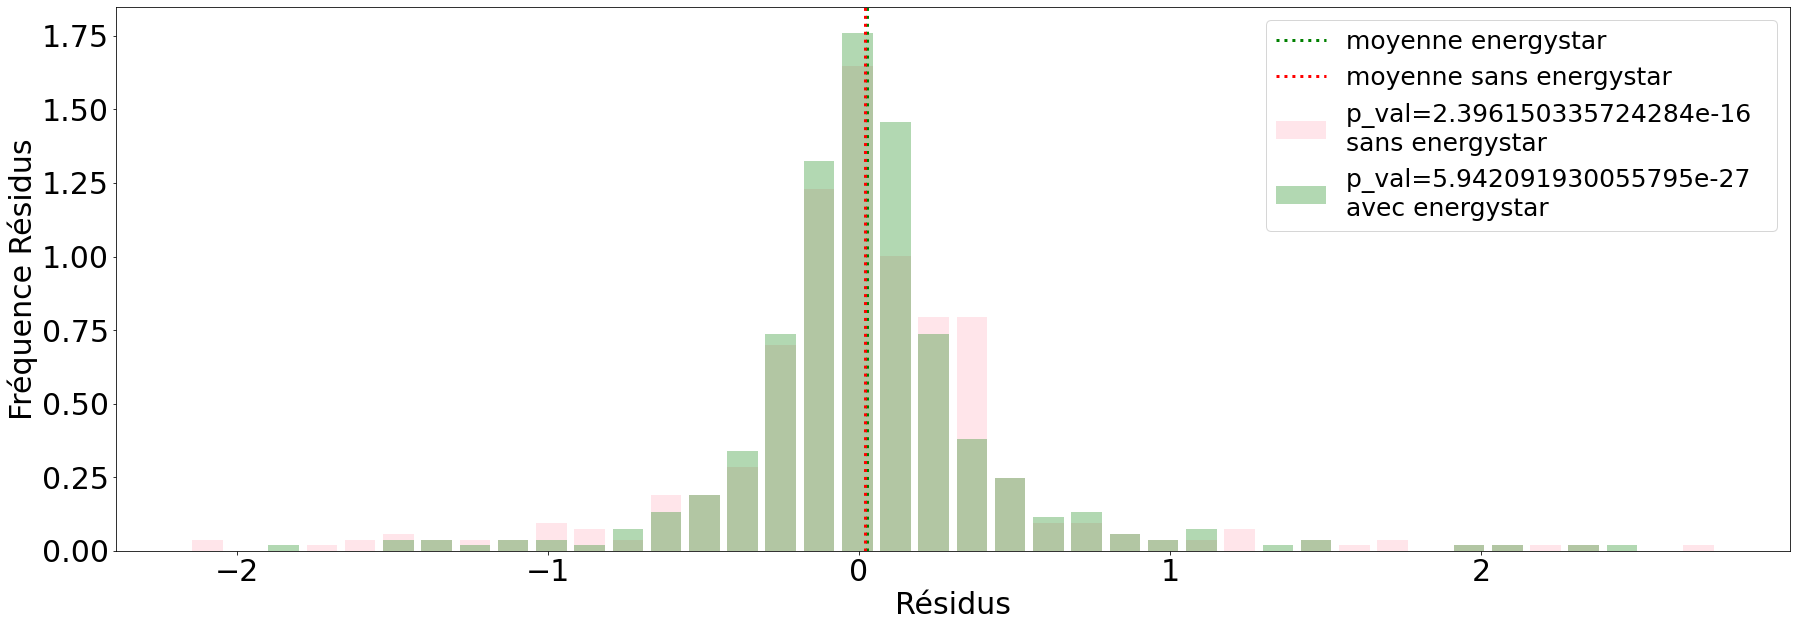

In [222]:
#normal test sur les residuels
import seaborn as s
_, p = normaltest(eps)
_, ps = normaltest(eps_s)

plt.figure(figsize = (30,10))
_,b,_ = plt.hist(eps_s, bins = 40, density = True, label= "p_val={}  \nsans energystar".format(ps), histtype = 'barstacked', rwidth=0.8, alpha = 0.4,color = 'pink')
plt.hist(eps, bins = b, density = True, label= "p_val={}  \navec energystar".format(p),histtype = 'barstacked', rwidth=0.8, alpha = 0.3, color = 'g')
plt.xlabel("Résidus", fontsize = 30)
plt.ylabel("Fréquence Résidus", fontsize = 30)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.axvline(x = np.mean(eps), color = 'g', linewidth = 3, linestyle = ':', label = "moyenne energystar")
plt.axvline(x = np.mean(eps_s), color = 'r', linewidth = 3, linestyle = ':', label = "moyenne sans energystar")

plt.legend(fontsize = 25)
plt.show()

In [223]:
np.median(eps_s)

0.015570627746048338

### Test statistique sur les résidus

<ipython-input-224-a6992e0c916b>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels = ax.get_yticks(), fontsize = 20)


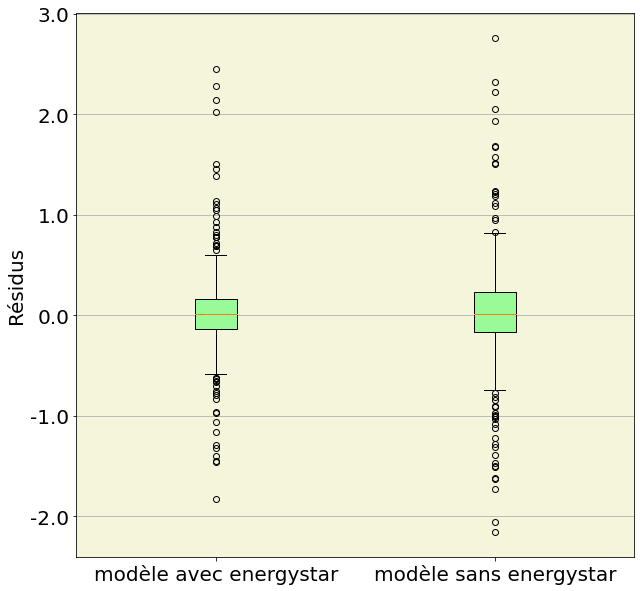

In [224]:
fig, ax = plt.subplots(figsize = (10, 10))
labels = ["modèle avec energystar", "modèle sans energystar"]
bplot = ax.boxplot([eps, eps_s], patch_artist = True)
for box in bplot['boxes']:
    box.set_facecolor('palegreen')
ax.patch.set_facecolor('beige')
ax.yaxis.grid(True)
ax.set_yticklabels(labels = ax.get_yticks(), fontsize = 20)
ax.set_xticklabels(labels =labels, fontsize = 20)
plt.ylabel("Résidus", fontsize = 20)
plt.show()

### Il n'y a pas de différence notable sur les médianes des résidus

In [225]:
print(kruskal(eps, eps_s))

KruskalResult(statistic=0.0499447672068527, pvalue=0.8231594107859693)


### Fisher test,  on compare les variance sur les résidus, la p value est ~ 0 on observe donce une différence significative sur les variances. La précision du modlèle apprit energy starscore est meilleure

In [226]:
# Comparaison des variances

df1 = len(eps_s) -1 # degre de liberté
df2 = len(eps) -1 # degre de liberté

# calcul de la statistique de Fisher
if np.var(eps_s) > np.var(eps):
    F = np.var(eps_s)/np.var(eps)  
else:
    F = np.var(eps)/np.var(eps_s)

pval = 1 - f.cdf(F, df1, df2)
pval

1.764211722976583e-05

### On compare les coefficient de correlations (ypred vs y) des deux modèle. La p value < 0.005, ce qui ous permet de conclure que la légère différence sur les coefficients de correlation est significative.

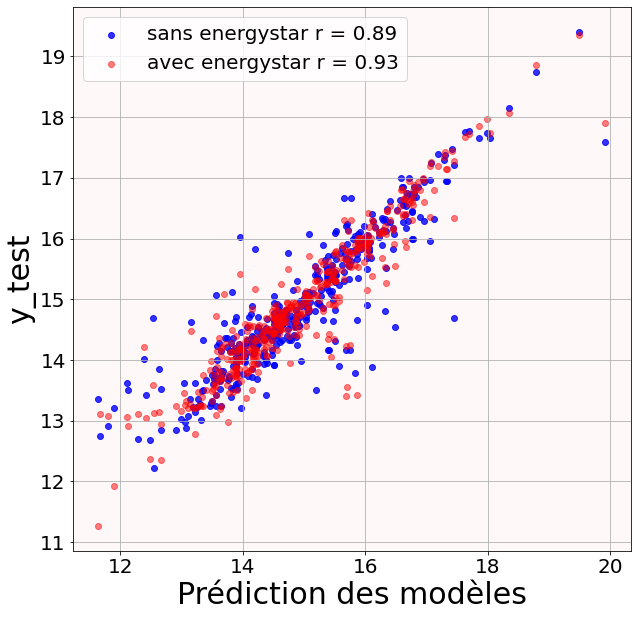

In [227]:
# Calcul coefficient de correlation Spearman
r, _ = spearmanr(y_test_s.ravel(),Rbest.predict(X_test))
r_s, _ = spearmanr(y_test_s.ravel(),Rbest_s.predict(X_test_s))

fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(y_test_s.ravel(),Rbest_s.predict(X_test_s),label="sans energystar r = {}".format(round(r_s, 2)), alpha = 0.8, color = 'b')
ax.scatter(y_test_s.ravel(),Rbest.predict(X_test), label="avec energystar r = {}".format(round(r, 2)), alpha = 0.5, color = 'r')
ax.set_xlabel("Prédiction des modèles", fontsize = 30)
ax.set_ylabel("y_test", fontsize = 30)
ax.tick_params(axis='x', labelsize= 20 )
ax.tick_params(axis='y', labelsize= 20 )
ax.patch.set_facecolor("pink")
ax.patch.set_alpha(0.1)
ax.grid()
plt.legend(fontsize = 20)
plt.show()

In [228]:
# transformation de Fisher 
rf = 0.5*np.log(np.abs((1+r)/(1-r))) # suit une loi normal  de moyenne 0 et d'écartype 1/np.sqrt(len[X_test[:, 0] - 3)
rf_s = 0.5*np.log(np.abs((1+r_s)/(1-r_s))) # suit une loi normal  de moyenne 0 et d'écartype 1/np.sqrt(len[X_test[:, 0] - 3)

# Calcul de la statistique Z (loi normale)
(rf-rf_s)/np.sqrt(2/(len(X_test[:, 0]) - 3)) # Statistique Z obtenue

#Calcul de la p value
pval = 1-norm.cdf(2.846112424231809, loc = 0, scale = 1)
print("On observe une différence de correlation entre r {} et r_s {} = {} avec une pval {}".format(r, r_s, r-r_s, pval))

On observe une différence de correlation entre r 0.9264775771146743 et r_s 0.8933237124858001 = 0.03315386462887415 avec une pval 0.00221282835094061
